## 1 D regresstion

In [1]:
# import tensorflow as tf
# from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import torch

import ipywidgets as widgets
from tqdm import tqdm
%matplotlib inline

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, layout, activation = torch.relu):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class Decoder(nn.Module):
    def __init__(self, layout, activation):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

        
    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class Aggregator(nn.Module):
    def __init__(self):
        super(Aggregator, self).__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=0)

class CNP(nn.Module):
    def __init__(self, layout_encoder, layout_decoder, activation):
        super(CNP, self).__init__()
        self.encoder = Encoder(layout_encoder, activation)
        self.decoder = Decoder(layout_decoder, activation)
        self.aggregator = Aggregator()
        
    def forward(self, contextx, contexty, targetx):
        context = torch.cat([contextx, contexty], dim=1)
        encoded_context = self.encoder(context)
        aggregated = self.aggregator(encoded_context)
        decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, contextx.shape[1])], dim=1)
        output = self.decoder(decoder_input)
        return output





# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(2, 256)
#         self.fc2 = nn.Linear(256, 256)
#         self.fc3 = nn.Linear(256, 256)
#         self.fc4 = nn.Linear(256, 128)


#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x

# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(129, 256)
#         self.fc2 = nn.Linear(256, 256)
#         self.fc3 = nn.Linear(256, 256)
#         self.fc4 = nn.Linear(256, 1)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x= F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x

# class Aggregator(nn.Module):
#     def __init__(self):
#         super(Aggregator, self).__init__()

#     def forward(self, x):
#         return torch.mean(x, dim=0)

# class cnp(nn.Module):
#     def __init__(self):
#         super(cnp, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = Decoder()
#         self.aggregator = Aggregator()

#     def forward(self, contextx, contexty, targetx):
#         context = torch.stack([contextx, contexty], dim=1)
#         encoded_context = self.encoder(context)
#         aggregated = self.aggregator(encoded_context)
#         decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, 1)], dim=1)
#         output = self.decoder(decoder_input)
#         return output



### Simple Sine Wave

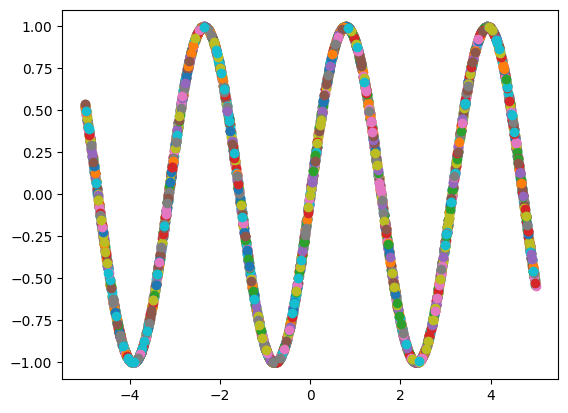

In [3]:
def generate_data_plot(num_samples, phase_shift = 0, frequency = 1, func = np.sin, amplitude = 1):
    x = np.random.uniform(-5, 5, num_samples)
    y = amplitude*func(frequency*x + phase_shift)
    plt.scatter(x, y)
    # plt.show()
    return x, y

def generate_data(num_samples, phase_shift = 0, frequency = 1, func = np.sin, amplitude = 1):
    x = np.random.uniform(-5, 5, num_samples)
    y =  amplitude*func(frequency*x + phase_shift)
    return x, y

training_data =[generate_data_plot(42, 0, 2, np.sin, 1) for i in range(100)]

In [4]:
import torch.optim as optim

def train(training_data, num_epochs = 1000, num_samples = 42, context_size = 10, target_size = 30):
    encoder_layout = [[2, 256], [256, 256], [256, 256], [256, 128]]
    decoder_layout = [[129, 256], [256, 256], [256, 256], [256, 1]]
    model = CNP(encoder_layout, decoder_layout, torch.relu)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []
    for epoch in tqdm(range(num_epochs)):
        context=np.random.choice(num_samples, context_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)
        train_set=np.random.randint(0, len(training_data))


        target_x=training_data[train_set][0][target]
        target_y=training_data[train_set][1][target]
        context_x=training_data[train_set][0][context]
        context_y=training_data[train_set][1][context]


        context_x = torch.tensor(context_x, dtype=torch.float32).view(-1,1)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        model.train()
        optimizer.zero_grad()
        predictions = model(context_x, context_y, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    plt.plot(np.arange(num_epochs), np.log(losses))
    plt.xlabel('Epochs')
    plt.ylabel("Loss (Log)")
    plt.title("Loss vs Epoch")
    plt.show()
    return model

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 617.08it/s]


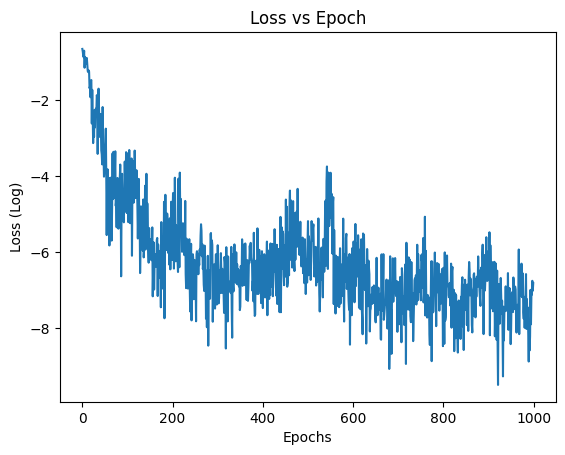

In [5]:
training_data = [generate_data(42) for i in range(100)]
model = train(training_data, 1000)

In [6]:
def testing(model, num_samples = 42, num_contexts = 10, num_test = 32, phase_shift = 0, frequency = 1, func = np.sin, amplitude = 1):
    test_data = generate_data(num_samples, phase_shift, frequency, func, amplitude)
    
    context=np.random.choice(num_samples, num_contexts, replace=False)
    target=np.random.choice(num_samples, num_test, replace=False)


    target_x=test_data[0][target]
    target_y=test_data[1][target]
    context_x=test_data[0][context]
    context_y=test_data[1][context]


    context_x = torch.tensor(context_x, dtype=torch.float32).view(-1, 1)
    context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
    target_x = torch.tensor(target_x, dtype=torch.float32).view(-1, 1)
    target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)
    predictions = model(context_x, context_y, target_x)

    plt.scatter(target_x, predictions.detach().numpy(), label='Prediction')
    plt.scatter(target_x, target_y, label="Actual", color='r')
    plt.scatter(context_x, context_y, label="Context Data", color='g')
    plt.legend()

widgets.interact(testing, model = widgets.fixed(model), num_samples = (30, 100, 1), num_contexts = (1, 100, 1), num_test = (1, 100, 1), phase_shift = (0, 10, 0.1), frequency = (0, 10, 0.1), func = [np.sin, np.cos], amplitude = (0, 10, 0.1))


interactive(children=(IntSlider(value=42, description='num_samples', min=30), IntSlider(value=10, description=…

<function __main__.testing(model, num_samples=42, num_contexts=10, num_test=32, phase_shift=0, frequency=1, func=<ufunc 'sin'>, amplitude=1)>

# Different Amplitude

100%|██████████| 1000/1000 [00:01<00:00, 622.81it/s]


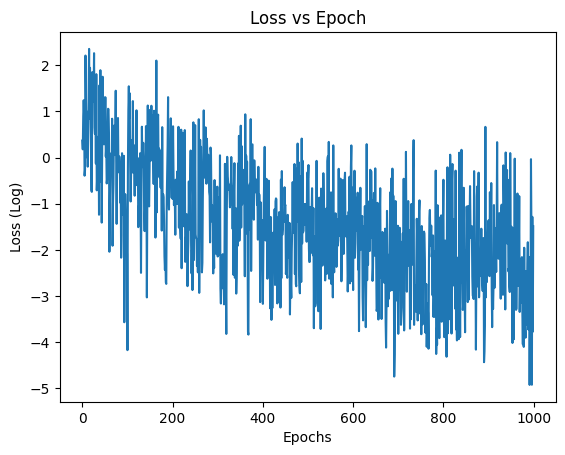

In [7]:

training_data = [generate_data(42, amplitude=np.random.uniform(1, 5)) for i in range(100)]
model2 = train(training_data, 1000)

In [8]:
widgets.interact(testing, model = widgets.fixed(model2), num_samples = (30, 100, 1), num_contexts = (1, 100, 1), num_test = (1, 100, 1), phase_shift = (0, 10, 0.1), frequency = (0, 10, 0.1), func = [np.sin, np.cos], amplitude = (0, 10, 0.1))


interactive(children=(IntSlider(value=42, description='num_samples', min=30), IntSlider(value=10, description=…

<function __main__.testing(model, num_samples=42, num_contexts=10, num_test=32, phase_shift=0, frequency=1, func=<ufunc 'sin'>, amplitude=1)>

# Different phase

100%|██████████| 1000/1000 [00:01<00:00, 630.59it/s]


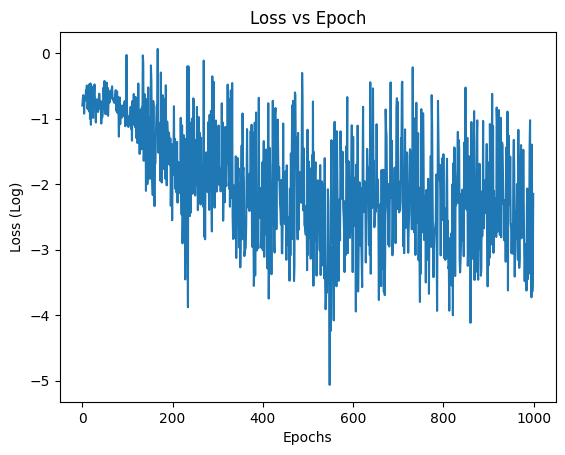

interactive(children=(IntSlider(value=42, description='num_samples', min=30), IntSlider(value=10, description=…

<function __main__.testing(model, num_samples=42, num_contexts=10, num_test=32, phase_shift=0, frequency=1, func=<ufunc 'sin'>, amplitude=1)>

In [9]:

training_data = [generate_data(42, phase_shift=np.random.uniform(1, 5)) for i in range(100)]
model3 = train(training_data, 1000)
widgets.interact(testing, model = widgets.fixed(model3), num_samples = (30, 100, 1), num_contexts = (1, 100, 1), num_test = (1, 100, 1), phase_shift = (0, 10, 0.1), frequency = (0, 10, 0.1), func = [np.sin, np.cos], amplitude = (0, 10, 0.1))


# Frequency

100%|██████████| 10000/10000 [00:17<00:00, 576.36it/s]


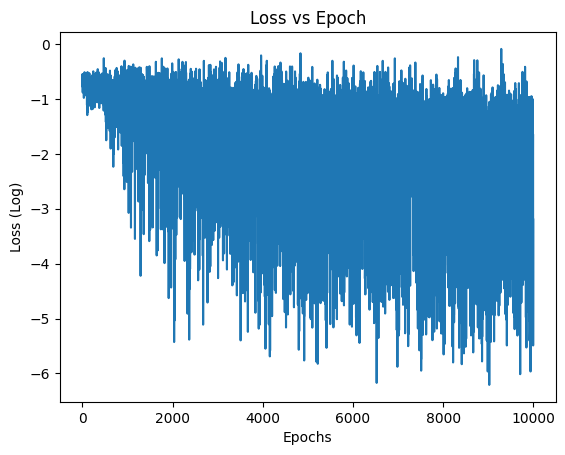

interactive(children=(IntSlider(value=42, description='num_samples', min=30), IntSlider(value=10, description=…

<function __main__.testing(model, num_samples=42, num_contexts=10, num_test=32, phase_shift=0, frequency=1, func=<ufunc 'sin'>, amplitude=1)>

In [12]:

training_data = [generate_data(100,frequency=np.random.uniform(1, 5)) for i in range(100)]
model4 = train(training_data, 10000, 100, 50, 70)
widgets.interact(testing, model = widgets.fixed(model4), num_samples = (30, 100, 1), num_contexts = (1, 100, 1), num_test = (1, 100, 1), phase_shift = (0, 10, 0.1), frequency = (0, 10, 0.1), func = [np.sin, np.cos], amplitude = (0, 10, 0.1))
